In [190]:
import sys
import matplotlib
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from colors import color
import sklearn as sl
import skimage
from sklearn.metrics import mean_squared_error as MSE
from data import Sample, smooth, Spectra
from scipy.optimize import basinhopping
from camera import CameraCalibration
from tmm.tmm_core import coh_tmm, unpolarized_RT
import copy
import os
from scipy.integrate import trapz

In [2]:
np.arange(10)

NameError: name 'np' is not defined

In [176]:
def NRMSE(y_true,y_pred):
    """
    Normalized Root-Mean-Square Error (NRMSE)
    :y_true: Ground truth (correct) target values,
    :y_pred: Predicted values
    :return:
    """
    cost = np.sqrt(MSE(y_true, y_pred)) / (y_true.max()-y_true.min())
    return cost

def NRMSE2(y_true,y_pred):
    """
    Normalized Root-Mean-Square Error (NRMSE)
    :y_true: Ground truth (correct) target values,
    :y_pred: Predicted values
    :return:
    """
    cost = np.linalg.norm((y_pred - y_true)/y_true) / np.sqrt(len(y_true))
    return cost

cost_function=MSE

mats_dir='mats/'
data_Si=np.loadtxt(mats_dir+'Si.txt')
data_PMMA=np.loadtxt(mats_dir+'PMMA.txt')
wl, n, k = data_Si[:,0], data_Si[:,1], data_Si[:,2]
Si_n= interp1d(wl, n)
Si_k= interp1d(wl, k)
wl, n = data_PMMA[:,0], data_PMMA[:,1]
PMMA_n= interp1d(wl, n)

#operational wavelenghts on which we are doing regression
nfiles=28
wavels = np.linspace(405, 740, 70)
filename_templates = ['Sample_%02d' %  i for i in range(1,nfiles)]
generate=False
samples_file='samples.npy'
if generate:
    samples = [Sample(file, 'Mirror', spectra_kargs={'transform' : smooth}, thick_file='thicknesses.pkl')
               for file in filename_templates]
    np.save(samples_file, samples)
else:
    samples = np.load(samples_file, allow_pickle=True)

def PMMA_n_extr(wl0):
    # Problem: PMMA refractive index defined only from 405nm. Solution:
    try:
        x = PMMA_n(wl0)
    except ValueError:
        x = PMMA_n(405.0)
    return x

def get_refl(wl0,d,n=PMMA_n_extr):
    nk_list = [1,n(wl0),Si_n(wl0)+1j*Si_k(wl0),1]
    d_list=[np.inf,d,20000,np.inf]
    return coh_tmm('s', nk_list, d_list, 0, wl0)['R']

def plot_spectra(d, **kargs):
    intensities = [get_refl(wl,d) for wl in wavels]
    plt.plot(wavels, intensities, **kargs)

def myfun(d, sample):
    y_pred = np.array([get_refl(wl,d) for wl in wavels])
    y_true = sample.spectra.f(wavels)
    return cost_function(y_true,y_pred)

def myfun_with_scaling(d, scaling, sample):
    y_pred = np.array([get_refl(wl,d) for wl in wavels])
    y_true = sample.spectra.f(wavels)*scaling
    return cost_function(y_true,y_pred)

def myfun_color(d, sample, camera:CameraCalibration):
    spectra = np.array([get_refl(wl, d) for wl in wavels])
    y_pred = camera.spectra_to_XYZ(wavels,spectra)
    y_true = sample.image.RGB
    return cost_function(y_true, y_pred)

def myfun_n_color(d, n, sample, camera:CameraCalibration):
    spectra = np.array([get_refl(wl, d, n) for wl in wavels])
    y_pred = camera.spectra_to_XYZ(wavels,spectra)
    y_true = sample.image.RGB
    return cost_function(y_true, y_pred)

def myfun_same_n_color(n, samples, camera:CameraCalibration, dmin=150,dmax=450, dn=50):
    ds = np.linspace(dmin,dmax,dn)
    cost_functions = np.zeros(len(samples))
    thicknesses = np.zeros(len(samples))
    for i, sample in enumerate(samples):
        tmp = [myfun_n_color(d,n,sample,camera) for d in ds]
        cost_functions[i]=np.min(tmp)
        thicknesses[i]=ds[np.argmin(tmp)]
    return cost_functions, thicknesses

In [171]:
camera = CameraCalibration.load('camera.npy')
dmin=150
dmax=500
sample=np.random.choice(samples)
sample=samples[26]
gt_thicknesses = np.array([sample.thickness for sample in samples])

In [172]:
cost, thick = myfun_same_n_color(lambda x: 2.0,samples,camera)
cost2, thick2 = myfun_same_n_color(lambda x: 1.49,samples,camera)
cost3, thick3 = myfun_same_n_color(PMMA_n,samples,camera)

KeyboardInterrupt: 

In [5]:
cost3, thick3 - gt_thicknesses

(array([  1.49560077e-04,   5.41483426e-04,   2.32263818e-04,
          1.56895364e-05,   2.82600923e-04,   5.03307896e-05,
          1.15615618e-04,   4.31023453e-05,   6.07723404e-05,
          1.69697518e-04,   2.92772165e-05,   2.76466366e-05,
          3.62449161e-05,   2.97627475e-05,   1.92268194e-05,
          6.42601758e-05,   3.32843266e-05,   6.59029334e-05,
          3.87009289e-05,   9.73033193e-05,   2.62185993e-05,
          5.97305827e-05,   1.12332821e-04,   3.49884160e-05,
          3.42857183e-04,   9.25366695e-05,   1.24839984e-04]),
 array([ -10.4032449 , -187.96495918,    1.50716327,    5.88491837,
           5.81212245,    4.84277551,   -4.40957143,   -5.22746939,
           1.48608163,    5.50263265,    4.78673469,    0.45028571,
           9.46583673,    4.88638776,    8.13238776,    2.23883673,
           3.84273469,    1.38463265,    2.24663265,   -4.40136735,
          -3.00402041,   -3.38657143,   -1.74667347,    5.59167347,
           6.43146939,    4.8213

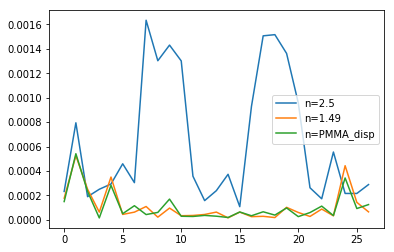

In [6]:
plt.plot(cost, label='n=2.5')
plt.plot(cost2, label='n=1.49')
plt.plot(cost3, label='n=PMMA_disp')
plt.legend()
plt.show()

In [184]:
%%time
import multiprocessing as mp
def processn(i):
    print("I'm process", os.getpid())
    
def cost_n(i,n):
    processn(i)
    return myfun_same_n_color(lambda x: n, samples,camera)

nlist = np.linspace(1,3,50)
cost_functions = np.zeros([len(nlist), len(samples)])
thicknesses = np.zeros([len(nlist), len(samples)])
# for i, n in enumerate(nlist):
#     cost_functions[i], thicknesses[i] = myfun_same_n_color(lambda x: n, samples,camera)

pool = mp.Pool(mp.cpu_count())
result_objects = [pool.apply_async(cost_n, args=[j,n])for j, n in enumerate(nlist)]
results = [r.get() for r in result_objects]
pool.close()
pool.join()

for i, (cf, tk) in enumerate(results):
    cost_functions[i] = cf
    thicknesses[i] = tk

I'm process 25841
I'm process 25842
I'm process 25843
I'm process 25844
I'm process 25847
I'm process 25845
I'm process 25846
I'm process 25859
I'm process 25857
I'm process 25863
I'm process 25860
I'm process 25862
I'm process 25856
I'm process 25858
I'm process 25865
I'm process 25861
I'm process 25864
I'm process 25848
I'm process 25849
I'm process 25851
I'm process 25850
I'm process 25854
I'm process 25852
I'm process 25855
I'm process 25864
I'm process 25865
I'm process 25863
I'm process 25862
I'm process 25861
I'm process 25860
I'm process 25859
I'm process 25857
I'm process 25855
I'm process 25858
I'm process 25851
I'm process 25856
I'm process 25850
I'm process 25852
I'm process 25854
I'm process 25849
I'm process 25848
I'm process 25847
I'm process 25846
I'm process 25845
I'm process 25844
I'm process 25843
I'm process 25842
I'm process 25841
I'm process 25864
I'm process 25863
CPU times: user 218 ms, sys: 1.28 s, total: 1.49 s
Wall time: 1min 43s


In [185]:
for i, (cf, tk) in enumerate(results):
    cost_functions[i] = cf
    thicknesses[i] = tk

In [7]:
[1,2,3]+[]

[1, 2, 3]

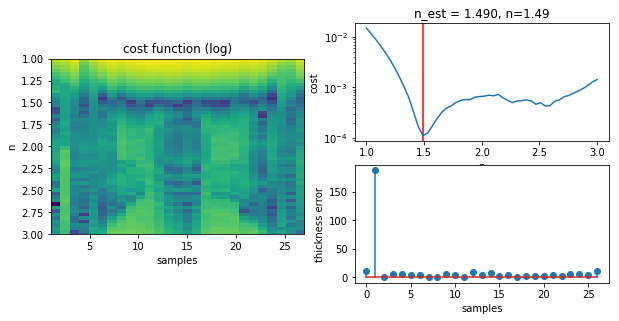

In [186]:
plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('cost function (log)')
plt.imshow(np.log(cost_functions),aspect=9,extent=[1,27,3,1])
plt.xlabel('samples')
plt.ylabel('n')
plt.subplot(422)
tmp = cost_functions.mean(axis=1)
ibest = cost_functions.mean(axis=1).argmin()
nest = nlist[cost_functions.mean(axis=1).argmin()]
plt.title('n_est = %.3f, n=1.49' % nest)
plt.axvline(nest,color='r', label='estimated refractive')
plt.plot(nlist,tmp)
plt.xlabel("n")
plt.ylabel('cost')
plt.yscale('log')
plt.subplot(424)
#plt.plot(np.abs(gt_thicknesses-thicknesses[ibest]), )
plt.stem(np.abs(gt_thicknesses-thicknesses[ibest]))
plt.xlabel("samples")
plt.ylabel("thickness error")
plt.show()

  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 2782, in stem
    'In Matplotlib 3.3 individual lines on a stem plot will be '
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 1993, in _warn_external
    warnings.warn(message, category, stacklevel)
/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 2782, in stem
    'In Matplotlib 3.3 individual lines on a stem plot will be '
  File "/ho

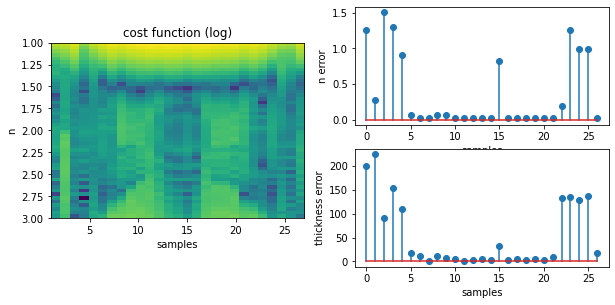

In [7]:
plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('cost function (log)')
plt.imshow(np.log(cost_functions),aspect=9,extent=[1,27,3,1])
plt.xlabel('samples')
plt.ylabel('n')
plt.subplot(422)
plt.xlabel("samples")
plt.ylabel('n error')
n_est = nlist[cost_functions.argmin(axis=0)]
plt.stem(np.abs(n_est-1.49))
ibest = cost_functions.argmin(axis=0)
plt.subplot(424)
plt.stem(np.abs(gt_thicknesses-thicknesses[ibest, np.arange(thicknesses.shape[1])]))
plt.xlabel("samples")
plt.ylabel("thickness error")
plt.show()

In [143]:
nlist[cost_functions.mean(axis=1).argmin()]

1.489795918367347

In [124]:
nlist[cost_functions.argmin(axis=0)]

array([ 2.67346939,  1.7755102 ,  3.        ,  2.71428571,  2.34693878,
        1.44897959,  1.48979592,  1.44897959,  1.48979592,  1.48979592,
        1.48979592,  1.48979592,  1.53061224,  1.53061224,  1.48979592,
        2.42857143,  1.48979592,  1.48979592,  1.48979592,  1.48979592,
        2.75510204,  1.48979592,  1.73469388,  1.44897959,  2.42857143,
        1.6122449 ,  1.44897959])

In [39]:
ibest

array([41, 18, 47, 42, 33, 10, 12, 11, 13, 13, 12, 12, 12, 12, 12, 31, 12,
       12, 12, 12, 11, 12, 16, 41, 35, 35, 11])

In [10]:
#%load_ext autoreload
#%autoreload 2
from dispersion import n_sellm0
n_sellm = n_sellm0(wl*1e-3,p=0.01113, r=1.1819)
PMMA_n_sellm = interp1d(wl, n_sellm)

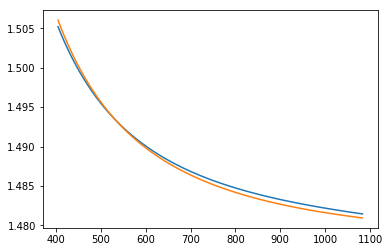

In [11]:
plt.plot(wl, PMMA_n(wl))
plt.plot(wl, PMMA_n_sellm(wl))

def show_disp(p,r, fname=None):
    n_sellm = n_sellm0(wl*1e-3,p=p, r=r)
    PMMA_n_sellm = interp1d(wl, n_sellm)
    n1 = PMMA_n
    n2 = PMMA_n_sellm
    plt.plot(wl,n1(wl),label='true')
    plt.plot(wl,n2(wl),label='model')
    plt.xlabel('wl')
    plt.ylabel('n')
    plt.legend()
    if fname is not None:
        plt.savefig(fname)
        plt.close()
    else:
        plt.show()

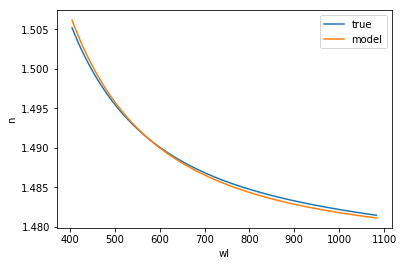

In [145]:
poles=np.linspace(.0,.1,100)
#96 = 2 * 48 (n processors on KW51)
residues=np.linspace(0.23,4,96)
#show_disp(p=np.random.choice(poles),r=np.random.choice(residues))
show_disp(p=poles[np.argmin(np.abs(poles-0.01113))],r=residues[np.argmin(np.abs(residues-1.1819))])
# for p in poles:
#     for r in residues:
#         n_sellm = n_sellm0(wl*1e-3,p=p, r=r)
#         PMMA_n_sellm = interp1d(wl, n_sellm)
#         plt.plot(wl,PMMA_n_sellm(wl))
# plt.show()

In [36]:
%%time
def processn(i):
    print("I'm process", os.getpid())

def cost_p_r(i,p,r):
    processn(i)
    n_sellm = n_sellm0(wl*1e-3,p=p, r=r)
    PMMA_n_sellm = interp1d(wl, n_sellm)
    return myfun_same_n_color(PMMA_n_sellm, samples,camera)
from IPython.display import clear_output
cost_functions_disp = np.zeros([len(poles), len(residues), len(samples)])
thicknesses_disp = np.zeros([len(poles), len(residues), len(samples)])
# for i, p in enumerate(poles[:1]):
#     for j, r in enumerate(residues[:8]):
#         clear_output()
#         print("current step %d, %d " % (i,j))
#         n_sellm = n_sellm0(wl*1e-3,p=p, r=r)
#         PMMA_n_sellm = interp1d(wl, n_sellm)
#         cost_functions_disp[i,j], thicknesses_disp[i,j] = myfun_same_n_color(PMMA_n_sellm, samples,camera)
p=0.01113
with mp.Pool(mp.cpu_count()) as pool:
    res=[pool.apply(cost_p_r, args=[j,p,r])for j, r in enumerate(residues[:8])]

I'm process 3640


Process ForkPoolWorker-60:
Process ForkPoolWorker-71:
Process ForkPoolWorker-57:
Process ForkPoolWorker-51:
Process ForkPoolWorker-63:
Process ForkPoolWorker-67:
Process ForkPoolWorker-50:
Process ForkPoolWorker-54:
Process ForkPoolWorker-70:
Process ForkPoolWorker-65:
Process ForkPoolWorker-68:
Process ForkPoolWorker-72:
Process ForkPoolWorker-64:
Process ForkPoolWorker-59:
Process ForkPoolWorker-66:
Process ForkPoolWorker-53:
Process ForkPoolWorker-61:
Process ForkPoolWorker-56:
Process ForkPoolWorker-55:
Process ForkPoolWorker-52:
Process ForkPoolWorker-58:
Traceback (most recent call last):
Process ForkPoolWorker-62:
Process ForkPoolWorker-69:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call l

  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in w

  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/makam0a/anaconda3/envs/prima/lib/pyt

KeyboardInterrupt: 

Process ForkPoolWorker-90:
Process ForkPoolWorker-118:
Process ForkPoolWorker-82:
Process ForkPoolWorker-77:
Process ForkPoolWorker-119:
Process ForkPoolWorker-108:
Process ForkPoolWorker-84:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Tra

  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/h

  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/hom

  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "

  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
Key

In [34]:
%%time

def processn():
    print("I'm process", os.getpid())
    
results = []
def collect_result(result):
    global results
    results.append(result)

def cost_p_r(p,r):
    n_sellm = n_sellm0(wl*1e-3,p=p, r=r)
    PMMA_n_sellm = interp1d(wl, n_sellm)
    return myfun_same_n_color(PMMA_n_sellm, samples,camera)
from IPython.display import clear_output
cost_functions_disp = np.zeros([len(poles), len(residues), len(samples)])
thicknesses_disp = np.zeros([len(poles), len(residues), len(samples)])
# for i, p in enumerate(poles[:1]):
#     for j, r in enumerate(residues[:8]):
#         clear_output()
#         print("current step %d, %d " % (i,j))
#         n_sellm = n_sellm0(wl*1e-3,p=p, r=r)
#         PMMA_n_sellm = interp1d(wl, n_sellm)
#         cost_functions_disp[i,j], thicknesses_disp[i,j] = myfun_same_n_color(PMMA_n_sellm, samples,camera)
for i, p in enumerate(poles):
    clear_output()
    print("current iteration %d, current pole %.4f" % (i, p))
    pool = mp.Pool(mp.cpu_count())
    result_objects = [pool.apply_async(cost_p_r, args=[p,r])for j, r in enumerate(residues)]
    results = [r.get() for r in result_objects]
    pool.close()
    pool.join()
    for j, (cf, tk) in enumerate(results):
        cost_functions_disp[i,j] = cf
        thicknesses_disp[i,j] = tk
    if i % 10 == 0:
        np.save('thicknesses_disp.npy', thicknesses_disp)
        np.save('cost_functions_disp.npy', cost_functions_disp)

current iteration 99, current pole 0.1000
CPU times: user 39.1 s, sys: 2min 21s, total: 3min
Wall time: 4h 28min 45s


In [44]:
np.save('thicknesses_disp0.npy', thicknesses_disp)
np.save('cost_functions_disp0.npy', cost_functions_disp)

In [46]:
disp_mse = np.zeros([len(poles),len(residues)])
def get_disp_mse(p,r):
    n_sellm = n_sellm0(wl*1e-3,p=p, r=r)
    PMMA_n_sellm = interp1d(wl, n_sellm)
    n1 = PMMA_n
    n2 = PMMA_n_sellm
    return MSE(n1(wl),n2(wl))
for i,p in enumerate(poles):
    for j, r in enumerate(residues):
        disp_mse[i,j] = get_disp_mse(p,r)

In [66]:
cost_functions_disp = np.load('cost_functions_disp0.npy')
thicknesses_disp = np.load('thicknesses_disp0.npy')

In [461]:
def neighbor_pooling(cost, nneighbors=1):
    cost_averaged = np.mean(cost,axis=2)
    nx, ny = cost.shape[:2]
    pooled_cost = np.zeros([nx,ny])
    for i in range(nx):
        for j in range(ny):
            tmp = 0
            for ix in range(-nneighbors,nneighbors):
                for iy in range(-nneighbors,nneighbors):
                    try:
                        tmp += cost_averaged[i+ix,j+iy]
                    except IndexError:
                        print("Boundary encountered!")
                        tmp += 0
            tmp /= (2*nneighbors+1)**2
            pooled_cost[i,j] = tmp
    return pooled_cost
            
pooled_cost = neighbor_pooling(cost_functions_disp,nneighbors=2)
pooled_cost
#np.mean(cost_functions_disp,axis=2)

Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary encountered!
Boundary e

array([[ 0.00205779,  0.00261827,  0.00306934, ...,  0.00053804,
         0.00055247,  0.00042057],
       [ 0.00221892,  0.0029051 ,  0.00347727, ...,  0.00044774,
         0.0004609 ,  0.00035042],
       [ 0.00237943,  0.00319192,  0.00388634, ...,  0.00035604,
         0.00036641,  0.0002769 ],
       ..., 
       [ 0.00173403,  0.00205575,  0.00227555, ...,  0.00070547,
         0.00071372,  0.00053847],
       [ 0.00173362,  0.00204561,  0.00225703, ...,  0.00071433,
         0.00072696,  0.00055161],
       [ 0.00130036,  0.00153042,  0.0016858 , ...,  0.00053886,
         0.00055064,  0.00041894]])

-9.13664157809


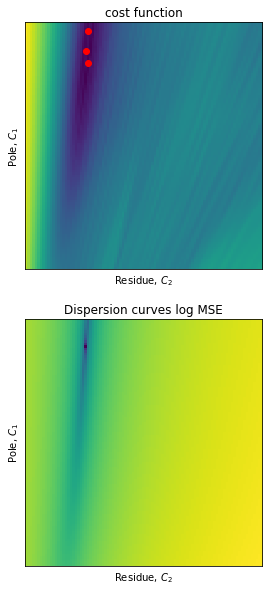

In [166]:
plt.figure(figsize=[20,10])
plt.subplot(211)
plt.title("cost function")
plt.imshow(np.log(np.mean(cost_functions_disp,axis=2)))
plt.ylabel('Pole, $C_1$')
plt.xlabel('Residue, $C_2$')
plt.xticks([])
plt.yticks([])
px = np.arange(len(poles))
px = np.arange(len(poles))
ix = np.argmin(np.abs(poles-0.01113))
iy = np.argmin(np.abs(residues-1.1819))
ix1, iy1 = divmod(np.argmin(np.log(np.mean(cost_functions_disp,axis=2))),cost_functions_disp.shape[1])
plt.plot([iy,iy1,iy+1], [ix,ix1,ix-8], 'or')
print(np.log(np.mean(cost_functions_disp,axis=2))[ix,iy])
plt.subplot(212)
plt.title("Dispersion curves log MSE")
plt.imshow(np.log(disp_mse))
plt.ylabel('Pole, $C_1$')
plt.xlabel('Residue, $C_2$')
plt.xticks([])
plt.yticks([])
plt.show()

-9.58224332546 -9.47389973078


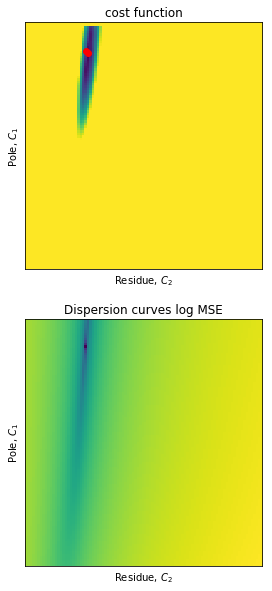

In [168]:
plt.figure(figsize=[20,10])
plt.subplot(211)
plt.title("cost function")
plt.imshow(np.log(pooled_cost),vmax=-9.2)
plt.ylabel('Pole, $C_1$')
plt.xlabel('Residue, $C_2$')
plt.xticks([])
plt.yticks([])
px = np.arange(len(poles))
px = np.arange(len(poles))
ix = np.argmin(np.abs(poles-0.01113))
iy = np.argmin(np.abs(residues-1.1819))
ix1, iy1 = divmod(np.argmin(np.log(pooled_cost)),cost_functions_disp.shape[1])
plt.plot([iy,iy1], [ix,ix1], 'or')
print(np.log(pooled_cost)[ix1,iy1],np.log(pooled_cost)[ix,iy])
plt.subplot(212)
plt.title("Dispersion curves log MSE")
plt.imshow(np.log(disp_mse))
plt.ylabel('Pole, $C_1$')
plt.xlabel('Residue, $C_2$')
plt.xticks([])
plt.yticks([])
plt.show()

In [104]:
ix1, iy1

(14, 26)

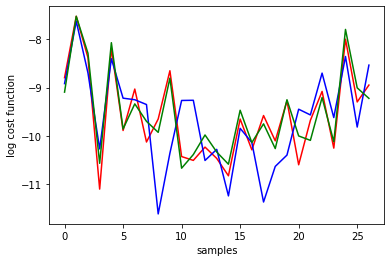

In [156]:
plt.plot(np.log(cost_functions_disp[ix,iy]),'r')
plt.plot(np.log(cost_functions_disp[ix1,iy1]),'b')
plt.plot(np.log(cost_functions_disp[ix-8,iy+1]),'g')
plt.ylabel('log cost function')
plt.xlabel('samples')
plt.show()

In [288]:
ix,iy

(16, 25)

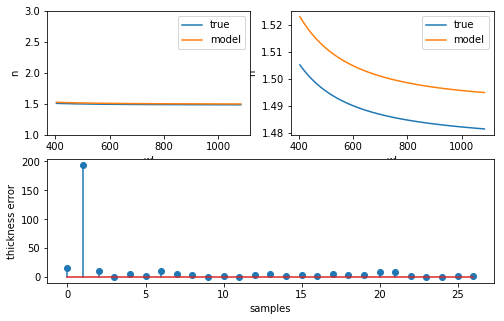

In [286]:
def show_disp_thick(i,j,p,r, fname=None):
    plt.figure(figsize=[8,5])
    plt.subplot(222)
    n_sellm = n_sellm0(wl*1e-3,p=p, r=r)
    PMMA_n_sellm = interp1d(wl, n_sellm)
    n1 = PMMA_n
    n2 = PMMA_n_sellm
    plt.plot(wl,n1(wl),label='true')
    plt.plot(wl,n2(wl),label='model')
    plt.xlabel('wl')
    plt.ylabel('n')
    plt.legend()
    plt.subplot(221)
    plt.plot(wl,n1(wl),label='true')
    plt.plot(wl,n2(wl),label='model')
    plt.xlabel('wl')
    plt.ylabel('n')
    plt.ylim(1,3)
    plt.legend()
    plt.subplot(212)
    plt.stem(np.abs(gt_thicknesses-thicknesses_disp[i,j]))
    plt.xlabel("samples")
    plt.ylabel("thickness error")
    if fname is not None:
        plt.savefig(fname)
        plt.close()
    else:
        plt.show()
show_disp_thick(ix,iy,poles[ix1], residues[iy1])

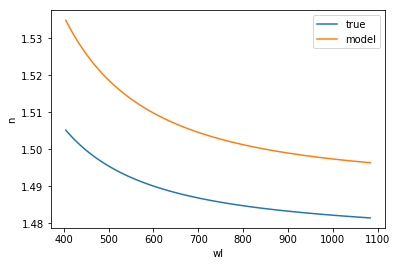

In [285]:
ix, iy = divmod(np.argmin(np.log(np.mean(cost_functions_disp,axis=2))),cost_functions_disp.shape[1])
np.log(np.mean(cost_functions_disp,axis=2))[ix,iy], np.min(np.log(np.mean(cost_functions_disp,axis=2)))
show_disp(poles[ix], residues[iy])

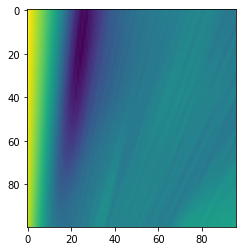

In [160]:
workdir='/home/makam0a/data/colors/'
figdir='/home/makam0a/data/colors/fig/'
fname = workdir+'matrix.txt'
log_disp_cost = np.log(np.mean(cost_functions_disp,axis=2))
with open(fname,'w') as file:
    plt.imshow(log_disp_cost)
    plt.show()
    for i,p in enumerate(poles):
        for j,r in enumerate(residues):
            status = 1
            intensity=log_disp_cost[i,j]
            print('%d %d %d %d %d %.3f' % (i,i,j,j,status,intensity),file=file)
            #show_disp_thick(i,j,p,r,fname=figdir+'fig-%d-%d.png' % (i,j))

In [286]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

Process ForkPoolWorker-32:
Process ForkPoolWorker-29:
Process ForkPoolWorker-28:
Process ForkPoolWorker-31:
Process ForkPoolWorker-27:
Process ForkPoolWorker-30:
Process ForkPoolWorker-33:
Process ForkPoolWorker-34:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/makam0a/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/makam0a/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/makam0a/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/makam0a/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 258, in _boots

In [462]:
min_idx = np.zeros(len(residues),dtype=np.int)
min_values = np.zeros(len(residues))
#pooled_cost = np.log(np.mean(cost_functions_disp,axis=2))
tmp = np.zeros([len(poles),len(residues)])
min_cost = 0
best_idx = []
for i, pole in enumerate(poles):
    for j,residue in enumerate(residues):
        disp = n_sellm0(wl*1e-3,p=pole,r=residue)
        tmp[i,j] = np.abs(trapz(disp-nest,wl))

In [343]:
divmod(tmp.argmin(),len(poles))

(12, 72)

In [436]:
idxs

(array([13, 53, 40, 27, 78, 66, 89, 26, 90, 65,  0, 14, 41, 12, 54, 77, 39,
        52, 28, 79]),
 array([24, 21, 22, 23, 19, 20, 18, 23, 18, 20, 25, 24, 22, 24, 21, 19, 22,
        21, 23, 19]))

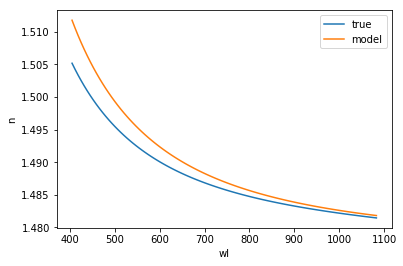

In [473]:
idxs = divmod(tmp.flatten().argsort()[:20],len(residues))
idxs = np.stack(idxs,axis=-1)
cost = np.zeros(idxs.__len__())
for k,(i,j) in enumerate(idxs):
    cost[k] = pooled_cost[i,j]
idx = idxs[cost.argsort()[1]]
show_disp(p=poles[idx[0]],r=residues[idx[1]])

In [440]:
idx = idxs[cost.argmin()]

In [421]:
target_pole = 0.01113
target_residue = 1.1819
percent=0.2
residue_min = target_residue - target_residue*percent
residue_max = target_residue + target_residue*percent
pole_min = target_pole - target_pole*0.1
pole_max = target_pole + target_pole*0.1
poles_ex = np.random.rand(30)*(pole_max-pole_min) + pole_min
residues_ex = np.random.rand(30)*(residue_max-residue_min) + residue_min

In [38]:
res_res = np.mean(residues_ex)
pol_res = np.mean(poles_ex)

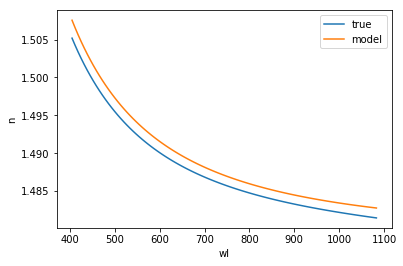

In [39]:
show_disp(p=pol_res, r=res_res)

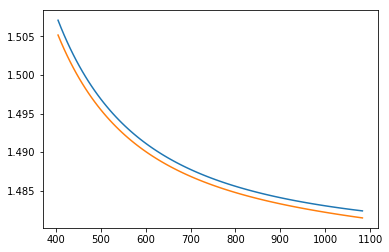

In [42]:
ans = np.zeros(len(wl))
for pole, residue in zip(poles_ex, residues_ex):
    ans += n_sellm0(wl*1e-3,p=pole, r=residue)
plt.plot(wl,ans/len(poles_ex))
plt.plot(wl,PMMA_n(wl))

1.489795918367347